# ST7 Planification quotidienne d’une équipe mobile

In [1]:
# Modules de base
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Utilités
from math import ceil
from utils import plot_map

## Formulation du problème

### Notation
- $ V $ : Nombre de tâches + 1 qui correspond au dépôt (V pour vertex)
- $ T $ : Nombre de techniciens
- $ i, j \in \{0, ..., V - 1\} $ : les indices des tâches
- $ k \in \{0, ..., T - 1 \} $ : les indices des techniciens
- $ (opening_i)_i $ : l’ouverture des sites
- $ (closing_i)_i $ : la fermeture des sites
- $ (start_k)_k $ : le début de travail des employés
- $ (end_k)_k $ : la fin de travail de chaque employé
- $ (duration_i)_i $ : la durée de chaque tâche
- $ (distance_{i, j}) $ : la distance entre les sites
- $ speed $ : la vitesse de déplacement des techniciens
- $ M $ : majorant pour notre problème



### Variables de décisions
- $ (x_{i, j})_{i, j} $, $ x_{i, j} = 1 $ ssi. (i, j) est un arc de i vers j
- $ (y_{k, i})_{k, i} $, $ y_{k, i} = 1 $ ssi. le technicien k effectue la tâche i
- $ (b_i)_i $, $B_i$ est le début de chaque tâche en minute (b pour beginning)
- $ (t_k)_k $ vaut 1 si l'employé i est actif (avec une tâche assignée ou plus)


### Objectif d’optimisation
$$ min \sum_{i, j = 0}^{V-1} x_{i, j} \cdot distance_{i, j} $$


### Contraintes
- (C1) : Il y a autant de techniciens actifs que d'arcs sortants du dépôt
$$ \sum_{j = 1}^{V-1} x_{0, j} = \sum_{k = 0}^{T-1} t_k $$

- (C2) Il y a autant d’arcs entrant du dépôt que d’arcs sortants du dépôt
$$ \sum_{i = 1}^{V-1} x_{0, i} = \sum_{i = 1}^{V-1} x_{i, 0} $$

- (C3) Le site de chaque tâche est visité par exactement un technicien
$$ \forall i \in \{1,\dots, V-1\}, \sum_{j = 1, j \ne i}^{V-1} x_{i, j} = \sum_{j = 1, j \ne i}^{V-1} x_{j, i} = 1 $$

- (C4) Deux tâches qui se suivent doivent être faites par le même technicien
$$ \forall i, j \in \{1,\dots, V-1\}, x_{i, j} \implies \forall k \in \{0,\dots, T-1\}, y_{k, i} = y_{k, j} \\
\equiv \forall i, j \in \{1,\dots, V-1\}, \forall k \in \{0,\dots, T-1\}, y_{k, i} \le y_{k, j} + M \cdot (1 - x_{i, j}) \text{ et } y_{k, j} \le y_{k, i} + M \cdot (1 - x_{i, j}) $$

- (C5) Lorsqu’un travail est effectué sur une tâche, la tâche doit être disponible.
$$ \forall i \in \{1,\dots, V-1\}, (b_i \ge opening_i) \land (b_i + duration_i \le closing_i) $$

- (C6) La fenêtre de temps entre deux travaux doit être suffisante pour le trajet
$$ \forall i, j \in \{1,\dots, V-1\}, x_{i, j} = 1 \implies b_i + duration_i + \frac{distance_{i, j}}{speed} \le b_j \\
\equiv \forall i, j \in \{1,\dots, V-1\}, b_i + duration_i + \frac{distance_{i, j}}{speed} \le b_j + M \cdot (1-x_{i, j}) $$

- (C7) Un technicien commence à l'heure
$$ \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, y_{k, i} \land x_{0, i} \implies start_k + \frac{distance_{0, i}}{speed} \le b_i \\
\equiv \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, start_k + \frac{distance_{0, i}}{speed} \le b_i + (2 - y_{k, i} - x_{0, i}) \cdot M $$

- (C8) Un technicien doit avoir suffisamment de temps pour rentrer au dét après sa dernière tâche
$$ \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, y_{k, i} \land x_{i, 0} \implies b_i + duration_i + \frac{distance_{i, 0}}{speed} \le end_k \\
\equiv \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, b_i + duration_i + \frac{distance_{i, 0}}{speed} \le end_k + (2 - y_{k, i} - x_{i, 0}) \cdot M $$

- (C9) Un technicien n’effectue que des tâches qu’il est capable d’effectuer
$$ \forall k \in \{0,\dots, T-1\}, \forall i \in \{1,\dots, V-1\}, levelTech_k \ge levelTask_i - M \cdot (1 - y_{k, i}) $$

- (C10) Une tâche est réalisée par un seul employé
$$ \forall i \in \{1,\dots, V-1\}, \sum_{k=0}^{T-1} y_{k, i} = 1 $$



## Implémentation d'employé et tâche

In [2]:
# importing Employee and Task classes
from models_v1 import Employee, Task
from utils import store_result

### Quelques démos de l’implémentation

In [3]:
from file_paths import path_bordeaux # path_finland, path_poland, path_italy, path_guinea_golf
path = path_bordeaux
path_result = "results/SolutionBordeauxV1ByV1.txt"

In [4]:
# reading dataframe into python objects
Employee.load_excel(path)
Task.load_excel(path, initialize_distance=True, load_depot=True)

In [5]:
T = len(Employee.list)
V = len(Task.list)
print(f"Fichier d’origine : \"{path}\"")
print(f"Nombre d’employés : {T}, Nombre de tâches : {V}")

Fichier d’origine : "./data/InstancesV1/InstanceBordeauxV1.xlsx"
Nombre d’employés : 2, Nombre de tâches : 11


Essayons maintenant d’afficher notre première tâche dans le fichier excel

In [6]:
# test on Task object
Task.list[1]

Task(id=T1, position=[-0.3193922422375719, 44.55654938342008], duration=60, skill_requirement=level 1 Oenology,opening_time=[08:00AM to 06:00PM] 

In [7]:
# loading opening_time, closing_time, duration into numpy arrays
opening_time = np.array([Task.list[i].opening_time for i in range(V)])
closing_time = np.array([Task.list[i].closing_time for i in range(V)])
duration = np.array([Task.list[i].duration for i in range(V)])

M = 1000000

## Implémentation

In [8]:
m = Model("DB")

# Decision variables
X = {(i, j) : m.addVar(vtype = GRB.BINARY, name = f'x{i}_{j}') for i in range(V) for j in range(V) if i != j}
Y = {(k, i) : m.addVar(vtype = GRB.BINARY, name = f'y{k}_{i}') for k in range(T) for i in range(V)}
B = {i : m.addVar(vtype = GRB.CONTINUOUS, name = f'b{i}', lb = 0) for i in range(V)}
t = {k : m.addVar(vtype = GRB.BINARY, name = f'k{k}') for k in range(T)}

# Constraints

# C1
for k in range(T):
    m.addConstr(t[k] <= quicksum([Y[(k,i)] for i in range(1,V)]))
    for i in range(1,V):
        m.addConstr(t[k] >= Y[(k,i)])
c1 = m.addConstr(quicksum([X[(0,j)] for j in range(1,V)])  == quicksum([t[k] for k in range(T)]))

# C2
c2 = {}
for i in range(1,V):
    c2[i] = m.addConstr(quicksum([X[(i,j)] for j in range(V) if i != j]) == quicksum([X[(j,i)] for j in range(V) if i != j]))
    
# C3
c3 = {}
for i in range(1,V):
    c2[i] = m.addConstr(quicksum([X[(i,j)] for j in range(V) if i != j]) == 1)
                      
# C4
C4  = {(i,j,k) : m.addConstr(Y[(k,i)] <= Y[(k,j)] + M*(1-X[(i,j)])) for i in range(1,V) for j in range(1,V) for k in range(T) if i != j}
C4b = {(i,j,k) : m.addConstr(Y[(k,i)] >= Y[(k,j)] - M*(1-X[(i,j)])) for i in range(1,V) for j in range(1,V) for k in range(T) if i != j}

# C5
C5o = {}
C5c = {}
for i in range(1,V):
    C5o[i] = m.addConstr(B[i] >= opening_time[i])
    C5c[i] = m.addConstr(duration[i] + B[i] <= closing_time[i])

# C6
C6 = {(i,j) : m.addConstr(B[i] + duration[i] + ceil(Task.distance[i,j]/Employee.speed) <= B[j] + M * (1-X[(i,j)]) ) for i in range(1,V) for j in range(1,V) if i != j}

# C7
C7 = {(k,i) : m.addConstr(Employee.list[k].start_time + ceil(Task.distance[0,i]/Employee.speed) - (2 - Y[(k,i)] - X[(0,i)]) * M <= B[i]) for k in range(T) for i in range(1,V)}

# C8
C8 = {(k,i) : m.addConstr(B[i] + duration[i] + ceil(Task.distance[i,0]/Employee.speed) <= Employee.list[k].end_time + M*(2-Y[(k,i)]-X[(i,0)])) for k in range(T) for i in range(1,V)}

# C9
C9 = {(k,i) : m.addConstr(Employee.list[k].level >= Task.list[i].level - M * (1 - Y[(k,i)]))  for k in range(T) for i in range(1,V)}

# C10
C10 = {i : m.addConstr(quicksum([Y[(k,i)] for k in range(T)]) == 1) for i in range(1,V)}

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-27


### Objective d'optimisation

In [9]:
obj = quicksum([X[(i,j)]*Task.distance[i,j] for i in range(V) for j in range(V) if i != j])
m.setObjective(obj, GRB.MINIMIZE)

In [10]:
m.params.outputflag = 0

m.update()

m.optimize()

In [11]:
assert m.status != GRB.INFEASIBLE

In [12]:
print("Techniciens actifs : {}".format([k for k in range(T) if t[k].x == 1]))

for k in range(T):
    print("Y_{} : {}".format(k,[i for i in range(1,V) if Y[(k,i)].x == 1]))
print()
for i in range(V):
    print([(i,j) for j in range(V) if i != j and X[(i,j)].x == 1])
print()
print(["B_{} : {}".format(i,B[i].x) for i in range(V)])

Techniciens actifs : [0, 1]
Y_0 : [3, 4, 5, 6, 7, 9]
Y_1 : [1, 2, 8, 10]

[(0, 9), (0, 10)]
[(1, 2)]
[(2, 0)]
[(3, 5)]
[(4, 6)]
[(5, 0)]
[(6, 3)]
[(7, 4)]
[(8, 1)]
[(9, 7)]
[(10, 8)]

['B_0 : 0.0', 'B_1 : 695.9999999999956', 'B_2 : 817.9999999999922', 'B_3 : 800.9999999999837', 'B_4 : 662.9999999999924', 'B_5 : 875.9999999999769', 'B_6 : 732.9999999999881', 'B_7 : 576.9999999999958', 'B_8 : 557.9999999999969', 'B_9 : 501.99999999999926', 'B_10 : 489.999999999999']


In [13]:
# Z associe un indice de tâche à l'employé qui l'effectue
Z = {}
for i in range(V):
    for k in range(T):
        if Y[(k,i)].x == 1:
            Z[i] = k

### Enregistrement des données dans le bon format

In [14]:
if not os.path.isdir(path_result):
    store_result(target_path=path_result,
                 employees=Employee.list,
                 tasks=Task.list, z=Z, b=B)

### Affichage de la distance totale

In [15]:
print(f"The total distance is {max([Task.distance[i,j] for i in range(V) for j in range(V)])/Employee.speed} km(s)")

The total distance is 127.79477073284689 km(s)


### Maintenant essayons d’utiliser notre visualiseur pour voir comment notre algorithem a réglé le problème

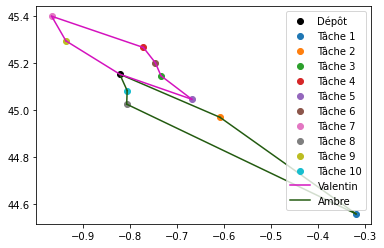

In [16]:
plot_map(V, Employee.list, Task.list, X, Z)

## Il suffit ensuite de changer les variables path et path_result pour faire les culculs sur les autres instances